In [1]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp
device=torch.device('cuda')

In [2]:
# path = '../input/understanding_cloud_organization'
# img_paths = '../input/understanding-clouds-resized'
path = './'
img_paths = './'
os.listdir(path)

['.vscode',
 'train_images_525',
 'sample_submission.csv',
 'catalyst',
 'submission.csv',
 'zerocenter_resnet50_90',
 'resnet50-clf.tar',
 'test_images',
 'b3_unet_576_384.ipynb',
 'utils.py',
 'test_images_half',
 'removal.clf',
 'resnet34-fpn-10folds-splits.txt',
 'b3-fpn-10folds-splits.txt',
 'logs',
 'train.csv',
 'b3-unet-rotated-pspnet-after.ipynb',
 'train_masks_525',
 'resize.ipynb',
 '__pycache__',
 'get_patch_stats.ipynb',
 'resnet34-unet.ipynb',
 'train_images_half',
 'b3_unet_640_320.ipynb',
 'b3-unet-rotated-pspnet.ipynb',
 'resnet34-unet_blurred.ipynb',
 'b3_unet_320_640.ipynb',
 'resnet34-unet-rotated.ipynb',
 'resnet50-classfier-full.ipynb',
 'examples',
 'swa.py',
 'b3-fpn.ipynb',
 'splits.txt',
 'apex',
 '.ipynb_checkpoints',
 'cloud.zip',
 'pytorch-deeplab-xception',
 'resnet34-fpn-valid.ipynb',
 'ensemble.ipynb',
 'my_models',
 'segmentation_models.pytorch',
 'test_images_525',
 'blurred_train_masks_525',
 'resnet50-classfier-80.ipynb',
 'train_images',
 'turbo-cha

In [3]:
def get_img(x, folder: str='train_images_525/train_images_525'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (350, 525)):
    """
    Create mask based on df, image name and shape.
    """
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    df = df[df["im_id"] == image_name]
    for idx, im_name in enumerate(df["im_id"].values):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread(os.path.join(f"{img_paths}/train_masks_525/train_masks_525/", classid + im_name))
            if mask is None:
                continue
            if mask[:,:,0].shape != (350,525):
                mask = cv2.resize(mask, (525,350))
            masks[:, :, classidx] = mask[:,:,0]
    masks = masks/255
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation(width=640, height=320):
    train_transform = [
        albu.Resize(height, width),
        albu.HorizontalFlip(p=0.25),
        albu.VerticalFlip(p=0.25),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0)
#         albu.GridDistortion(p=0.5),
#         albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(width=640, height=320):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height, width)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = {
        'image' : lambda x : to_tensor(preprocessing_fn(x)),
        'mask' : to_tensor
    }
    return _transform


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

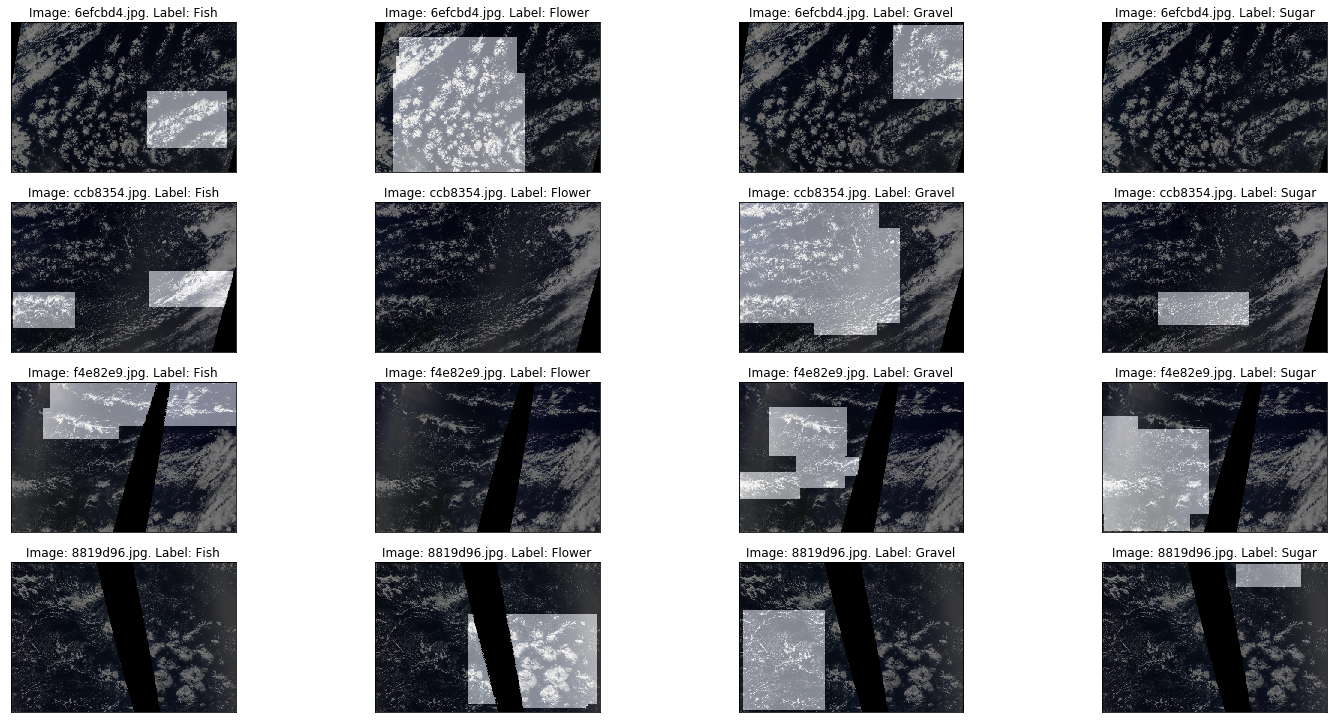

In [4]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{img_paths}/train_images_525/train_images_525/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask = cv2.imread(f"{img_paths}/train_masks_525/train_masks_525/{row['label']}{row['Image_Label'].split('_')[0]}", 0)
        if mask is None:
            mask = np.zeros((350, 525))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})

In [5]:
splits_dict = torch.load('splits.txt')

In [6]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{img_paths}/train_images_half"
        else:
            self.data_folder = f"{img_paths}/test_images_half"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            img = self.preprocessing['image'](img)
            mask = self.preprocessing['mask'](mask)
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [7]:
def prepare_loaders(train_ids, valid_ids, width, height, preprocessing_fn):
    num_workers = 4
    bs = 7
    train_dataset = CloudDataset(df=train, 
                                 datatype='train',
                                 img_ids=train_ids, 
                                 transforms=get_training_augmentation(width, height),
                                 preprocessing=get_preprocessing(preprocessing_fn))
    valid_dataset = CloudDataset(df=train, 
                                 datatype='valid', 
                                 img_ids=valid_ids, 
                                 transforms=get_validation_augmentation(width, height), 
                                 preprocessing=get_preprocessing(preprocessing_fn))

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

    loaders = {
        "train": train_loader,
        "valid": valid_loader
    }
    
    return loaders

In [8]:
from collections import OrderedDict
from catalyst.dl.callbacks.metrics import DiceCallback
from catalyst.dl.callbacks import CriterionCallback
from catalyst.dl.callbacks.checkpoint import CheckpointCallback
from catalyst.contrib.criterion import BCEDiceLoss
from catalyst.contrib.optimizers import RAdam, Lookahead
from catalyst.dl.callbacks.optimizer import OptimizerCallback
from apex import amp

In [9]:
i = 0

In [ ]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
    zerocenter='norm'
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_ids, valid_ids = splits_dict[i]
width = 320
height = 640
loaders = prepare_loaders(train_ids, valid_ids, width, height, preprocessing_fn)

num_epochs = 15
logdir = "./logs/" + ENCODER + "-unet_{0}_{1}-".format(width, height) + str(i)

# model, criterion, optimizer
optimizer = RAdam([
    {'params': model.encoder.parameters(), 'lr': 1e-3},
    {'params': model.decoder.parameters(), 'lr': 1e-2},
], weight_decay=1e-4)
optimizer = Lookahead(optimizer)
opt_level = 'O1'
model.cuda()
#model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
criterion = {
    'loss' : BCEDiceLoss(eps=1., bce_weight=0.5, dice_weight=0.5)
}
runner = SupervisedRunner()

callbacks = OrderedDict()
callbacks['dice'] = DiceCallback(threshold=0.5)
callbacks['criterion'] = CriterionCallback(prefix="loss", criterion_key="loss")
callbacks['checkpoint'] = CheckpointCallback(save_n_best=4)
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    main_metric='loss',
    minimize_metric=True,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=False
)
!find ./logs | grep full.pth | xargs rm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2019-11-14 20:33:24,509] 
1/15 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=206.2655 | _timers/batch_time=0.0350 | _timers/data_time=0.0113 | _timers/model_time=0.0236 | dice=0.4470 | loss=0.5731
1/15 * Epoch 1 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=240.8211 | _timers/batch_time=0.0332 | _timers/data_time=0.0167 | _timers/model_time=0.0164 | dice=0.5442 | loss=0.4660
[2019-11-14 20:38:16,337] 
2/15 * Epoch 2 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=201.0515 | _timers/batch_time=0.0358 | _timers/data_time=0.0118 | _timers/model_time=0.0240 | dice=0.5315 | loss=0.4458
2/15 * Epoch 2 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=240.3650 | _timers/batch_time=0.0331 | _timers/data_time=0.0164 | _timers/model_time=0.0167 | dice=0.5540 | loss=0.4448
[2019-11-14 20:43:04,310] 
3/15 * Epoch 3 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=202.6881 | _timers/batch_time=0.0355 | _time

In [ ]:
from swa import bn_update
pths = []
for pth in os.listdir(os.path.join(logdir, 'checkpoints')):
    if 'train' in pth and 'full' not in pth:
        pth_path = os.path.join(logdir, 'checkpoints', pth)
        pths.append(torch.load(pth_path)['model_state_dict'])
for i in range(1, len(pths)):
    alpha = 1 / float(i + 1)
    for key in pths[0]:
        pths[0][key] = alpha * (pths[0][key] * float(i) + pths[i][key])
model.load_state_dict(pths[0])
bn_update(loaders['train'], model)
torch.save(model.state_dict(), os.path.join(logdir, 'swa.pth'))

In [ ]:
import ttach as tta

class PredModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        self.sig = torch.nn.Sigmoid()
    
    def forward(self, x):
        return self.sig(self.model.predict(x))

In [ ]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
    zerocenter='norm'
)
checkpoint = torch.load(os.path.join(logdir, 'swa.pth'))
model.load_state_dict(checkpoint)
model = PredModel(model)
model = tta.SegmentationTTAWrapper(model, tta.aliases.hflip_transform (), merge_mode='mean')
model.cuda()

In [ ]:
valid_probs = []
sig = torch.nn.Sigmoid()
with torch.no_grad():
    for i, (image, _) in enumerate(tqdm.tqdm(loaders['valid'])):
        output = model(image.cuda())

        for j, batch in enumerate(output):
            for probability in batch:
                probability = probability.detach().cpu().numpy()
                if probability.shape != (350, 525):
                    probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                valid_probs.append(probability.astype(np.float16))

valid_probs = np.stack(valid_probs)

valid_masks = []
for _, masks in tqdm.tqdm(loaders['valid']):
    for mask in masks:
        for m in mask:
            if m.shape != (350, 525):
                m = cv2.resize(m.numpy(), dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            valid_masks.append(m.astype(np.float16))

valid_masks = np.stack(valid_masks)

In [ ]:
from multiprocessing import Pool

class_params = {}

def get_class_param(class_id):
    print(class_id)
    attempts = []
    for t in [30, 35, 45, 50, 55, 60, 65, 70]:
        t /= 100
        for ms in [5000, 10000, 15000, 20000, 22500, 25000]:
            masks = []
            for i in range(class_id, len(valid_probs), 4):
                probability = valid_probs[i]
                predict, num_predict = post_process(probability.astype(np.float32), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])


    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    best_dice = attempts_df['dice'].values[0]
    
    class_params[class_id] = (best_threshold, best_size, best_dice)
    return class_params[class_id]

for i in range(4):
    class_params[i] = get_class_param(i)

In [ ]:
def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        elif mode=='approx':
            epsilon = 0.02*cv2.arcLength(c,True)
            approx = cv2.approxPolyDP(c,epsilon,True)
            cv2.drawContours(img, [approx], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

In [ ]:
class_id = 0
d = []

for p, v in zip(valid_probs, valid_masks):
    predict, num_predict = post_process(
                p.astype(np.float32), class_params[class_id][0], class_params[class_id][1])
    predict = draw_convex_hull(predict.astype(np.uint8), 'convex')
    if (predict.sum() == 0) & (v.sum() == 0):
        d.append(1)
    else:
        d.append(dice(predict, v))
            
    class_id += 1
    class_id = class_id % 4

np.mean(d)